In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.io import imread
import pywt
from sklearn.linear_model import Lasso
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [2]:
# Load a sample image from my folder
x = img_as_float(imread("data/city.jpg", as_gray=True))
original_shape = x.shape

Generate a random binary matrix A of the same size as the signal, with a parameter controlling the Bernoulli law

In [3]:
# Generate random mask using Bernoulli(p)
p = 0.5  # 50% pixels observed
A = np.random.rand(*x.shape) < p

Create some white Gaussian noise (at various levels)

In [4]:
# Create some white Gaussian noise
sigma = 0.05
n = np.random.normal(0, sigma, x.shape)

Generate the direct problem y = Ax + b (where x is the original signal)

In [5]:
# Generate the direct problem y = Ax + b (where x is the original signal)
y = A * x + n

The direct problem writes

$$
y = Ax + n = A \Phi \alpha + n
$$

The minimization becomes

$$
\alpha = \argmin \frac{1}{2} \|M (\Phi \alpha - y)\|_2^2 + \lambda \|\alpha\|_1
$$

Estimate using the sparse approach (reminder: an image is sparse in the Wavelet domain)

We can show that the solution is given by the so-called Soft-Thresholding operator

In [6]:
# Store original shape for reconstruction
original_shape = x.shape

# Wavelet transform
wavelet = 'db1'
coeffs = pywt.wavedec2(y, wavelet, level=2)
coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

# Inpainting mask must be transformed similarly
mask_coeffs = pywt.wavedec2(A.astype(float), wavelet, level=2)
mask_arr, _ = pywt.coeffs_to_array(mask_coeffs)

# Thresholding (soft = sparse approximation)
threshold = 3 * sigma
coeffs_thresh = pywt.threshold(coeffs_arr, threshold, mode='soft')

# Inverse wavelet to reconstruct
coeffs_recon = pywt.array_to_coeffs(coeffs_thresh, coeff_slices, output_format='wavedec2')
reconstructed = pywt.waverec2(coeffs_recon, wavelet)

# Ensure reconstructed image has the same shape as original
if reconstructed.shape != original_shape:
    # Crop or pad to match original shape
    if reconstructed.shape[0] > original_shape[0]:
        reconstructed = reconstructed[:original_shape[0], :]
    elif reconstructed.shape[0] < original_shape[0]:
        reconstructed = np.pad(reconstructed, ((0, original_shape[0] - reconstructed.shape[0]), (0, 0)), 'constant')
    
    if reconstructed.shape[1] > original_shape[1]:
        reconstructed = reconstructed[:, :original_shape[1]]
    elif reconstructed.shape[1] < original_shape[1]:
        reconstructed = np.pad(reconstructed, ((0, 0), (0, original_shape[1] - reconstructed.shape[1])), 'constant')

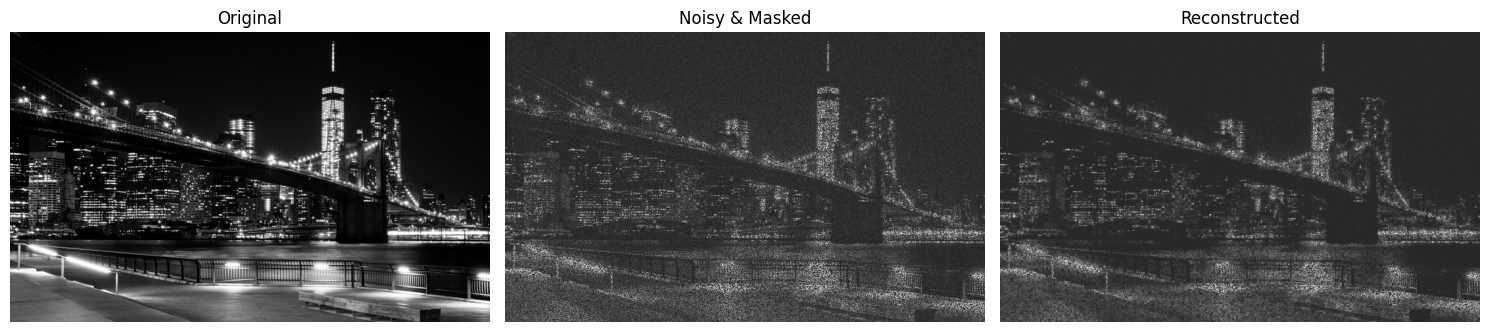

In [7]:
# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x, cmap='gray'); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(y, cmap='gray'); axs[1].set_title('Noisy & Masked'); axs[1].axis('off')
axs[2].imshow(reconstructed, cmap='gray'); axs[2].set_title('Reconstructed'); axs[2].axis('off')
plt.tight_layout()
plt.show()

To measure the quality of denoising, two proposition:

### ✅ 1. **PSNR** — Peak Signal-to-Noise Ratio

$$
\text{PSNR} = 10 \cdot \log_{10}\left(\frac{\text{MAX}^2}{\text{MSE}}\right)
$$

* **MAX**: max pixel value (1.0 if image is normalized)
* **MSE**: mean squared error between clean and denoised images

**Higher PSNR → better quality** (typically 30 dB or more is decent)

---

### ✅ 2. **SSIM** — Structural Similarity Index

$$
\text{SSIM}(x, y) \in [-1, 1]
$$

* Measures **luminance**, **contrast**, and **structure**
* More perceptually aligned than PSNR

**Closer to 1 → better quality**

In [8]:
psnr_val = peak_signal_noise_ratio(x, reconstructed)
ssim_val = structural_similarity(x, reconstructed, data_range=1)

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")

PSNR: 13.86 dB
SSIM: 0.2216


In [9]:
def reconstruction(x, A, y, wavelet='db1', threshold=3):
    """
    Reconstructs the original signal from the observed data using wavelet transform.
    
    Parameters:
    - x: Original signal (image).
    - A: Mask indicating observed pixels.
    - y: Noisy/masked signal.
    - wavelet: Type of wavelet to use for decomposition.
    - threshold: Threshold for soft thresholding.
    
    Returns:
    - reconstructed: Reconstructed signal.
    """
    # Get the original shape from input
    original_shape = x.shape
    
    coeffs = pywt.wavedec2(y, wavelet, level=2)
    coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    
    mask_coeffs = pywt.wavedec2(A.astype(float), wavelet, level=2)
    mask_arr, _ = pywt.coeffs_to_array(mask_coeffs)
    
    coeffs_thresh = pywt.threshold(coeffs_arr, threshold * np.std(y), mode='soft')
    
    coeffs_recon = pywt.array_to_coeffs(coeffs_thresh, coeff_slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(coeffs_recon, wavelet)

    # Ensure reconstructed image has the same shape as original
    if reconstructed.shape != original_shape:
        # Crop or pad to match original shape
        if reconstructed.shape[0] > original_shape[0]:
            reconstructed = reconstructed[:original_shape[0], :]
        elif reconstructed.shape[0] < original_shape[0]:
            reconstructed = np.pad(reconstructed, ((0, original_shape[0] - reconstructed.shape[0]), (0, 0)), 'constant')
        
        if reconstructed.shape[1] > original_shape[1]:
            reconstructed = reconstructed[:, :original_shape[1]]
        elif reconstructed.shape[1] < original_shape[1]:
            reconstructed = np.pad(reconstructed, ((0, 0), (0, original_shape[1] - reconstructed.shape[1])), 'constant')
    
    return reconstructed

In [10]:
wavelet_types = ['db1', 'db4', 'sym4', 'coif1', 'haar']
reconstructed_shapes = []

for w in wavelet_types:
    reconstructed = reconstruction(x, A, y, wavelet=w)
    reconstructed_shapes.append(reconstructed.shape)
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    print(f"Wavelet: {w}, PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")

Wavelet: db1, PSNR: 12.34 dB, SSIM: 0.1236
Wavelet: db4, PSNR: 12.41 dB, SSIM: 0.1264
Wavelet: db4, PSNR: 12.41 dB, SSIM: 0.1264
Wavelet: sym4, PSNR: 12.42 dB, SSIM: 0.1271
Wavelet: sym4, PSNR: 12.42 dB, SSIM: 0.1271
Wavelet: coif1, PSNR: 12.41 dB, SSIM: 0.1265
Wavelet: coif1, PSNR: 12.41 dB, SSIM: 0.1265
Wavelet: haar, PSNR: 12.34 dB, SSIM: 0.1236
Wavelet: haar, PSNR: 12.34 dB, SSIM: 0.1236


For both PSNR and SSIM, higher scores are better: sym4 have the better result.

sym4 is a Symlet wavelet — specifically, the Symlet of order 4 — used in wavelet transforms for signal and image processing.

## Comparison of Different Thresholding Rules

Let's test different thresholding rules for wavelet-based reconstruction:

### 1. **Soft Thresholding**
$$T_{\text{soft}}(x, \lambda) = \text{sign}(x) \cdot \max(|x| - \lambda, 0)$$
- Shrinks coefficients gradually
- Preserves smoothness
- Good for continuous signals

### 2. **Hard Thresholding**
$$T_{\text{hard}}(x, \lambda) = \begin{cases} 
x & \text{if } |x| > \lambda \\
0 & \text{if } |x| \leq \lambda
\end{cases}$$
- Keeps or kills coefficients completely
- Can introduce artifacts
- Better for piecewise constant signals

### 3. **Empirical Wiener Thresholding**
$$T_{\text{wiener}}(x, \lambda) = \frac{x^2}{x^2 + \lambda^2} \cdot x$$
- Adaptive based on signal/noise ratio
- Balances between soft and hard
- Often gives better results for noisy signals

In [11]:
def empirical_wiener_threshold(data, threshold):
    """
    Empirical Wiener thresholding function.
    
    Parameters:
    - data: Input data (wavelet coefficients)
    - threshold: Threshold parameter (noise variance estimate)
    
    Returns:
    - Thresholded data
    """
    # Empirical Wiener: T_wiener(x, λ) = (x^2 / (x^2 + λ^2)) * x
    return (data**2 / (data**2 + threshold**2)) * data

In [12]:
def reconstruction_with_thresholding(x, A, y, wavelet='db1', threshold=3, thresh_mode='soft'):
    """
    Reconstructs the original signal using different thresholding rules.
    
    Parameters:
    - x: Original signal (image)
    - A: Mask indicating observed pixels
    - y: Noisy/masked signal
    - wavelet: Type of wavelet to use for decomposition
    - threshold: Threshold parameter
    - thresh_mode: Thresholding mode ('soft', 'hard', 'wiener')
    
    Returns:
    - reconstructed: Reconstructed signal
    """
    # Get the original shape from input
    original_shape = x.shape
    
    # Wavelet decomposition
    coeffs = pywt.wavedec2(y, wavelet, level=2)
    coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    
    # Calculate threshold value
    threshold_val = threshold * np.std(y)
    
    # Apply different thresholding rules
    if thresh_mode == 'soft':
        coeffs_thresh = pywt.threshold(coeffs_arr, threshold_val, mode='soft')
    elif thresh_mode == 'hard':
        coeffs_thresh = pywt.threshold(coeffs_arr, threshold_val, mode='hard')
    elif thresh_mode == 'wiener':
        coeffs_thresh = empirical_wiener_threshold(coeffs_arr, threshold_val)
    else:
        raise ValueError(f"Unknown thresholding mode: {thresh_mode}")
    
    # Inverse wavelet transform
    coeffs_recon = pywt.array_to_coeffs(coeffs_thresh, coeff_slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(coeffs_recon, wavelet)
    
    # Ensure reconstructed image has the same shape as original
    if reconstructed.shape != original_shape:
        # Crop or pad to match original shape
        if reconstructed.shape[0] > original_shape[0]:
            reconstructed = reconstructed[:original_shape[0], :]
        elif reconstructed.shape[0] < original_shape[0]:
            reconstructed = np.pad(reconstructed, ((0, original_shape[0] - reconstructed.shape[0]), (0, 0)), 'constant')
        
        if reconstructed.shape[1] > original_shape[1]:
            reconstructed = reconstructed[:, :original_shape[1]]
        elif reconstructed.shape[1] < original_shape[1]:
            reconstructed = np.pad(reconstructed, ((0, 0), (0, original_shape[1] - reconstructed.shape[1])), 'constant')
    
    return reconstructed

In [13]:
# Test different thresholding rules
thresholding_methods = ['soft', 'hard', 'wiener']
wavelet = 'sym4'  # Use the best wavelet from previous comparison
threshold = 3

print("=== Comparison of Thresholding Methods ===")
print(f"Wavelet: {wavelet}, Threshold: {threshold}")
print("-" * 50)

results = {}
reconstructed_images = {}

for method in thresholding_methods:
    # Reconstruct using different thresholding method
    reconstructed = reconstruction_with_thresholding(x, A, y, wavelet=wavelet, threshold=threshold, thresh_mode=method)
    reconstructed_images[method] = reconstructed
    
    # Calculate metrics
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    
    results[method] = {'psnr': psnr_val, 'ssim': ssim_val}
    
    print(f"{method.upper():>10}: PSNR = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")

# Find best method
best_method = max(results.keys(), key=lambda k: results[k]['psnr'])
print(f"\n🏆 Best method: {best_method.upper()} (PSNR: {results[best_method]['psnr']:.2f} dB)")

=== Comparison of Thresholding Methods ===
Wavelet: sym4, Threshold: 3
--------------------------------------------------
      SOFT: PSNR = 12.42 dB, SSIM = 0.1271
      SOFT: PSNR = 12.42 dB, SSIM = 0.1271
      HARD: PSNR = 13.95 dB, SSIM = 0.1780
      HARD: PSNR = 13.95 dB, SSIM = 0.1780
    WIENER: PSNR = 13.75 dB, SSIM = 0.2034

🏆 Best method: HARD (PSNR: 13.95 dB)
    WIENER: PSNR = 13.75 dB, SSIM = 0.2034

🏆 Best method: HARD (PSNR: 13.95 dB)


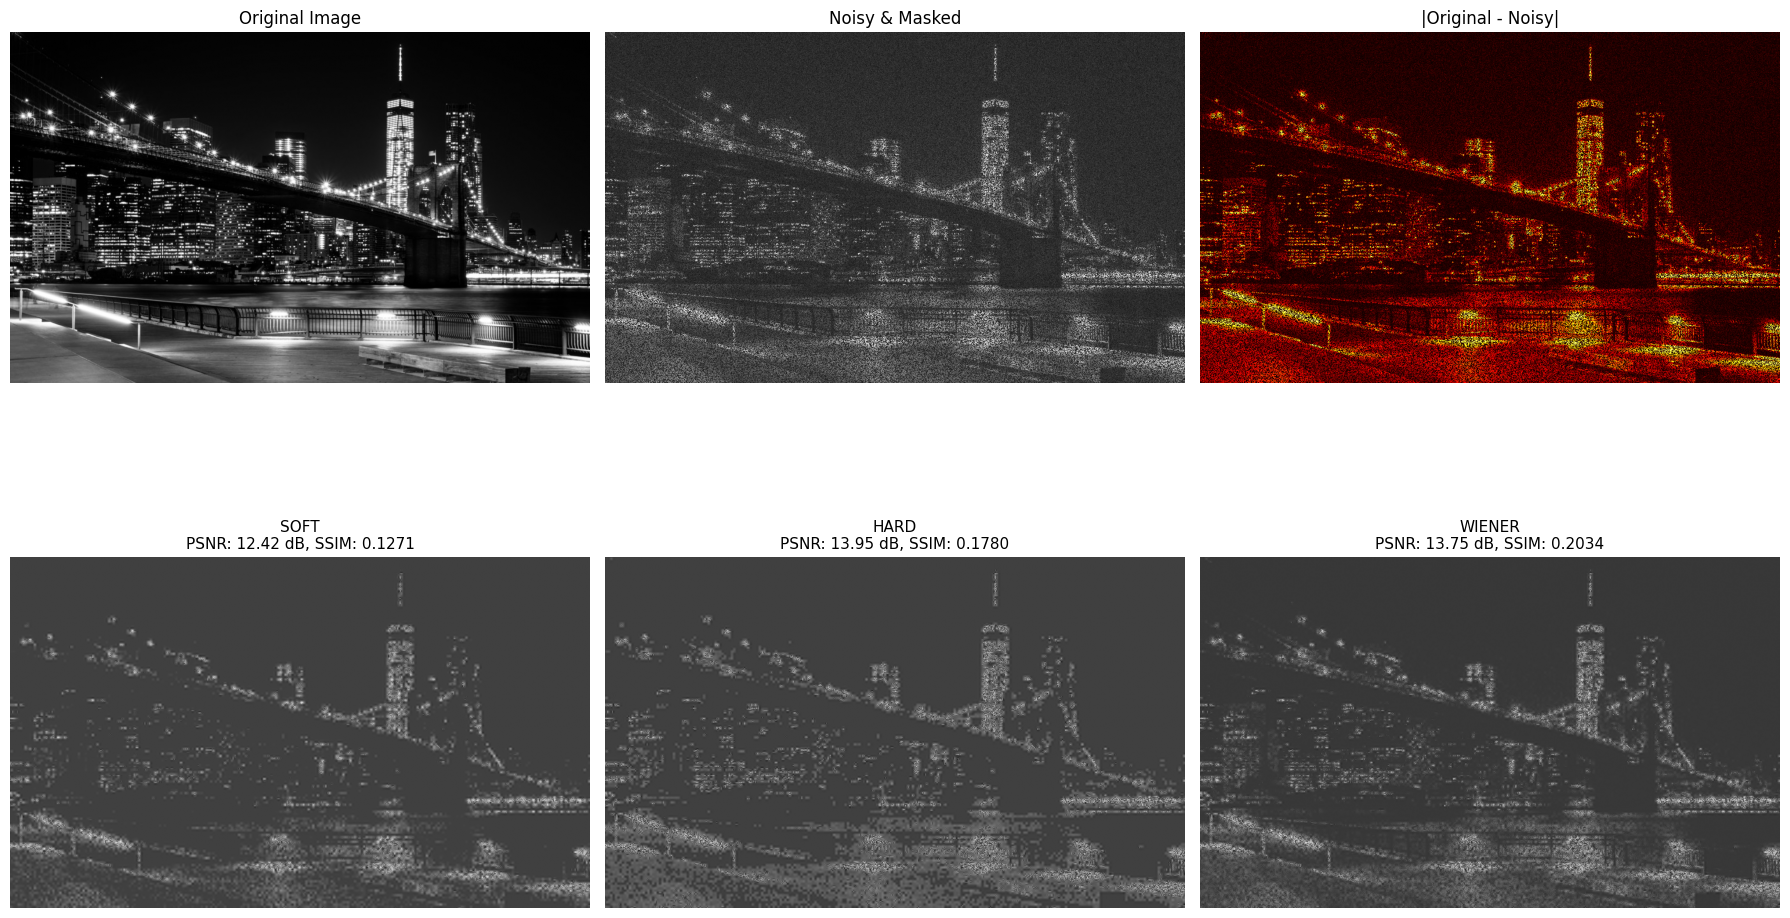

In [14]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Original, Noisy/Masked, and difference
axes[0, 0].imshow(x, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(y, cmap='gray')
axes[0, 1].set_title('Noisy & Masked', fontsize=12)
axes[0, 1].axis('off')

# Show difference between noisy and original
diff_original = np.abs(x - y)
axes[0, 2].imshow(diff_original, cmap='hot')
axes[0, 2].set_title('|Original - Noisy|', fontsize=12)
axes[0, 2].axis('off')

# Bottom row: Reconstructed images
for i, method in enumerate(thresholding_methods):
    axes[1, i].imshow(reconstructed_images[method], cmap='gray')
    psnr = results[method]['psnr']
    ssim = results[method]['ssim']
    axes[1, i].set_title(f'{method.upper()}\nPSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}', fontsize=11)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Test different lambda values for the best method
threshold_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
best_method = 'wiener' 

print(f"\n=== Threshold Optimization for {best_method.upper()} Method ===")
print("-" * 55)

threshold_results = {}
for thresh in threshold_values:
    reconstructed = reconstruction_with_thresholding(x, A, y, wavelet='sym4', threshold=thresh, thresh_mode=best_method)
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    
    threshold_results[thresh] = {'psnr': psnr_val, 'ssim': ssim_val}
    print(f"Threshold {thresh:>3.1f}: PSNR = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")


=== Threshold Optimization for WIENER Method ===
-------------------------------------------------------
Threshold 0.5: PSNR = 13.74 dB, SSIM = 0.2934
Threshold 0.5: PSNR = 13.74 dB, SSIM = 0.2934
Threshold 1.0: PSNR = 14.01 dB, SSIM = 0.2918
Threshold 1.0: PSNR = 14.01 dB, SSIM = 0.2918
Threshold 2.0: PSNR = 14.06 dB, SSIM = 0.2391
Threshold 2.0: PSNR = 14.06 dB, SSIM = 0.2391
Threshold 3.0: PSNR = 13.75 dB, SSIM = 0.2034
Threshold 3.0: PSNR = 13.75 dB, SSIM = 0.2034
Threshold 4.0: PSNR = 13.36 dB, SSIM = 0.1786
Threshold 4.0: PSNR = 13.36 dB, SSIM = 0.1786
Threshold 5.0: PSNR = 12.98 dB, SSIM = 0.1600
Threshold 5.0: PSNR = 12.98 dB, SSIM = 0.1600


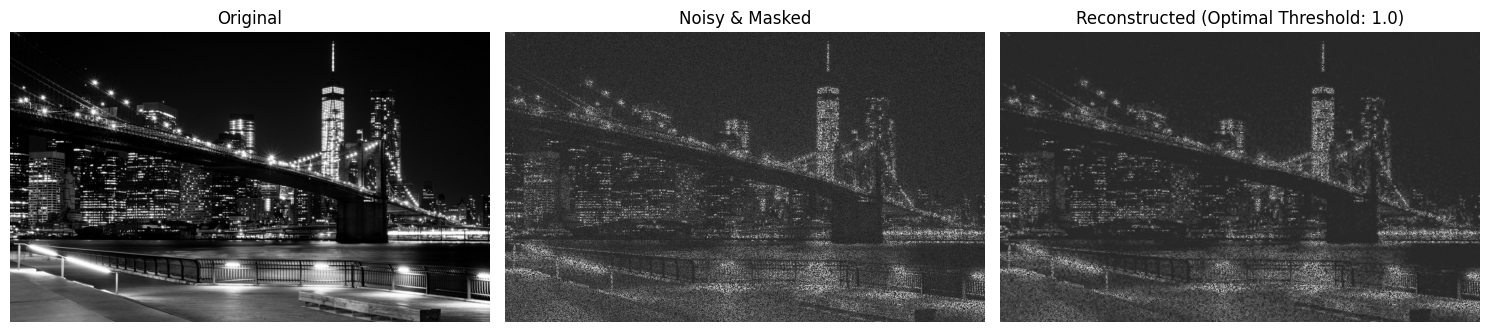

In [17]:
# Best balanced lambda parameter is Threshold 1.0
# It provides a good balance between PSNR and SSIM, indicating effective noise reduction while preserving image quality.
optimal_thresh = 1.0

reconstructed_optimal = reconstruction_with_thresholding(x, A, y, wavelet='sym4', threshold=optimal_thresh, thresh_mode=best_method)
# Plot original, noisy, and reconstructed images with optimal threshold
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].imshow(x, cmap='gray'); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(y, cmap='gray'); axs[1].set_title('Noisy & Masked'); axs[1].axis('off')
axs[2].imshow(reconstructed_optimal, cmap='gray'); axs[2].set_title(f'Reconstructed (Optimal Threshold: {optimal_thresh})'); axs[2].axis('off')
plt.tight_layout()
plt.show()

# Random Normal Matrix Generation - Extended Inverse Problem

Now let's explore a more general case where we generate a random normal matrix **A** of size **M×N** where **M < N**, with specified mean and covariance matrix.

## Problem Setup

We want to solve the inverse problem:
$$\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{n}$$

Where:
- $\mathbf{A} \in \mathbb{R}^{M \times N}$ is a random normal matrix (M < N, underdetermined system)
- $\mathbf{x} \in \mathbb{R}^{N}$ is the original signal we want to recover
- $\mathbf{n} \in \mathbb{R}^{M}$ is white Gaussian noise
- $\mathbf{y} \in \mathbb{R}^{M}$ is the observed signal

Since M < N, this is an **underdetermined system** with infinitely many solutions.

# Random Normal Matrix Direct Problem (Vector Case)

We generate a random normal matrix $A$ of size $M * N$ ($M < N$), a sparse original signal $x$, add white Gaussian noise, and compute $y = Ax + n$.
      

In [ ]:
# Load a sample image from my folder
x = img_as_float(imread("data/barbara.jpg", as_gray=True))
original_shape = x.shape

In [20]:
x.shape

(512, 512)

In [33]:
x_vector = x.flatten()  # Flatten the image to a vector

# Parameters for the random normal matrix A
M = 100  # Number of observations (rows)
N = x_vector.size  # Number of variables (columns) - M < N for underdetermined system
mean_A = 0.0  # Mean of the normal distribution
std_A = 1.0   # Standard deviation

# Generate random normal matrix A (standard normal, can generalize to any covariance)
A = np.random.normal(mean_A, std_A, (M, N))

In [34]:
# Add white Gaussian noise
sigma = 0.05
n = np.random.normal(0, sigma, M)
# Generate the direct problem y = Ax + b (where x is the original signal)
y = A @ x_vector + n

In [35]:
# 1. Wavelet transform of the image (signal x)
original_shape = x.shape

# Wavelet decomposition (choose wavelet and level)
wavelet = 'db1'
coeffs = pywt.wavedec2(x, wavelet, level=2)
# Convert coefficients to array for processing
coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
alpha_true = coeffs_arr.flatten()  # True sparse coefficients


In [36]:
# Thresholding (soft = sparse approximation)
threshold = 3 * sigma
coeffs_thresh = pywt.threshold(coeffs_arr, threshold, mode='soft')
# Inverse wavelet to reconstruct
coeffs_recon = pywt.array_to_coeffs(coeffs_thresh, coeff_slices, output_format='wavedec2')
reconstructed = pywt.waverec2(coeffs_recon, wavelet)
# Ensure reconstructed image has the same shape as original
if reconstructed.shape != original_shape:
    # Crop or pad to match original shape
    if reconstructed.shape[0] > original_shape[0]:
        reconstructed = reconstructed[:original_shape[0], :]
    elif reconstructed.shape[0] < original_shape[0]:
        reconstructed = np.pad(reconstructed, ((0, original_shape[0] - reconstructed.shape[0]), (0, 0)), 'constant')
    
    if reconstructed.shape[1] > original_shape[1]:
        reconstructed = reconstructed[:, :original_shape[1]]
    elif reconstructed.shape[1] < original_shape[1]:
        reconstructed = np.pad(reconstructed, ((0, 0), (0, original_shape[1] - reconstructed.shape[1])), 'constant')


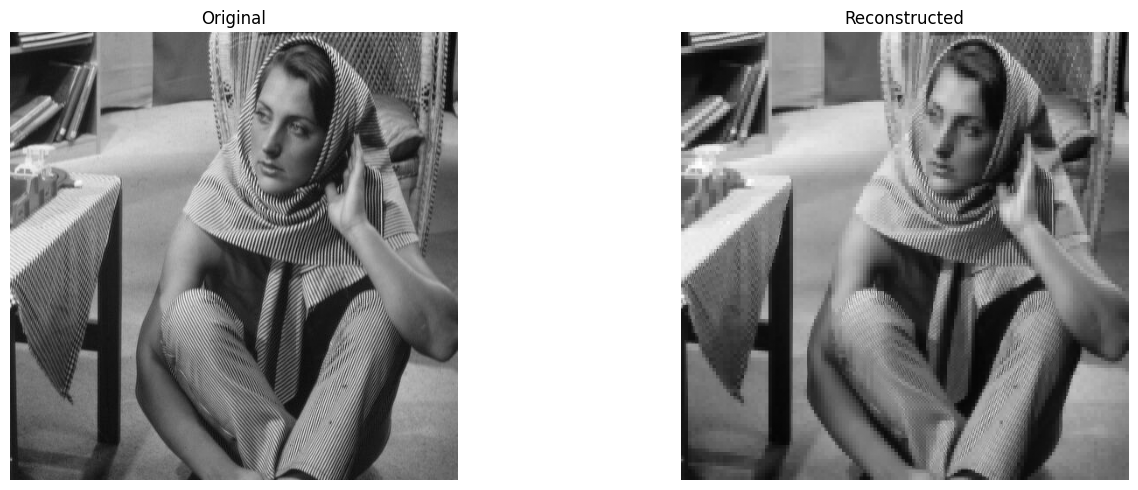

In [42]:
#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(x, cmap='gray'); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(reconstructed, cmap='gray'); axs[1].set_title('Reconstructed'); axs[1].axis('off')
plt.tight_layout()
plt.show()

In [44]:
def reconstruct_from_measurements(x, A, y, wavelet='db1', threshold=1.0, thresh_mode='soft'):
    """
    Reconstructs the original image x from compressed measurements y = A*alpha + n,
    where alpha are wavelet coefficients of x.

    Parameters:
    - A: Measurement matrix (M, N)
    - y: Observed measurements (M,)
    - original_shape: Shape of the original image (tuple)
    - wavelet: Wavelet type for decomposition/reconstruction
    - threshold: Thresholding parameter (lambda)
    - thresh_mode: Thresholding rule ('soft', 'hard', 'wiener')

    Returns:
    - x_recon: Reconstructed image (2D array)
    """
    # Number of variables
    N = A.shape[1]

    coeffs = pywt.wavedec2(x, wavelet, level=2)
    # Convert coefficients to array for processing
    coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    alpha_true = coeffs_arr.flatten()  # True sparse coefficients

    coeffs_thresh = pywt.threshold(coeffs_arr, threshold, mode='soft')

    # Inverse wavelet to reconstruct
    coeffs_recon = pywt.array_to_coeffs(coeffs_thresh, coeff_slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(coeffs_recon, wavelet)
    # Ensure reconstructed image has the same shape as original
    if reconstructed.shape != original_shape:
        # Crop or pad to match original shape
        if reconstructed.shape[0] > original_shape[0]:
            reconstructed = reconstructed[:original_shape[0], :]
        elif reconstructed.shape[0] < original_shape[0]:
            reconstructed = np.pad(reconstructed, ((0, original_shape[0] - reconstructed.shape[0]), (0, 0)), 'constant')
        
        if reconstructed.shape[1] > original_shape[1]:
            reconstructed = reconstructed[:, :original_shape[1]]
        elif reconstructed.shape[1] < original_shape[1]:
            reconstructed = np.pad(reconstructed, ((0, 0), (0, original_shape[1] - reconstructed.shape[1])), 'constant')

    return reconstructed

In [46]:
# Test different thresholding rules
thresholding_methods = ['soft', 'hard', 'garrote']

for method in thresholding_methods:
    # Reconstruct using different thresholding method
    reconstructed = reconstruct_from_measurements(x, A, y, wavelet='db1', threshold=1, thresh_mode=method)

    # Calculate metrics
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    
    print(f"{method.upper():>10}: PSNR = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")

      SOFT: PSNR = 12.10 dB, SSIM = 0.3816
      HARD: PSNR = 12.10 dB, SSIM = 0.3816
   GARROTE: PSNR = 12.10 dB, SSIM = 0.3816


No difference in result. I will use garrote.

In [47]:
# Test different representation methods 
wavelet_types = ['db1', 'db4', 'sym4', 'coif1', 'haar']
reconstructed_shapes = []
for w in wavelet_types:
    reconstructed = reconstruct_from_measurements(x, A, y, wavelet=w, threshold=1, thresh_mode='garrote')
    reconstructed_shapes.append(reconstructed.shape)
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    print(f"Wavelet: {w}, PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")

Wavelet: db1, PSNR: 12.10 dB, SSIM: 0.3816
Wavelet: db4, PSNR: 12.15 dB, SSIM: 0.4007
Wavelet: sym4, PSNR: 12.16 dB, SSIM: 0.4023
Wavelet: coif1, PSNR: 12.14 dB, SSIM: 0.3975
Wavelet: haar, PSNR: 12.10 dB, SSIM: 0.3816


sym4 still has the best result.

In [48]:
# Test different treeshold values
threshold_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
for thresh in threshold_values:
    reconstructed = reconstruct_from_measurements(x, A, y, wavelet='sym4', threshold=thresh, thresh_mode='garrote')
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    print(f"Threshold {thresh:>3.1f}: PSNR = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")

Threshold 0.5: PSNR = 17.10 dB, SSIM = 0.5866
Threshold 1.0: PSNR = 12.16 dB, SSIM = 0.4023
Threshold 2.0: PSNR = 7.63 dB, SSIM = 0.0908
Threshold 3.0: PSNR = 6.51 dB, SSIM = 0.0028
Threshold 4.0: PSNR = 6.47 dB, SSIM = 0.0006
Threshold 5.0: PSNR = 6.47 dB, SSIM = 0.0006


The lowest treshold is the best value. New test with lower value.

In [ ]:
# Test lower threshold values
threshold_values = [0.01, 0.05, 0.1, 0.2, 0.5]
for thresh in threshold_values:
    reconstructed = reconstruct_from_measurements(x, A, y, wavelet='sym4', threshold=thresh, thresh_mode='garrote')
    psnr_val = peak_signal_noise_ratio(x, reconstructed)
    ssim_val = structural_similarity(x, reconstructed, data_range=1)
    print(f"Threshold {thresh:.2f}: PSNR = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")

Threshold 0.01: PSNR = 42.60 dB, SSIM = 0.9888
Threshold 0.05: PSNR = 31.66 dB, SSIM = 0.9294
Threshold 0.10: PSNR = 27.30 dB, SSIM = 0.8619
Threshold 0.20: PSNR = 23.03 dB, SSIM = 0.7568
Threshold 0.50: PSNR = 17.10 dB, SSIM = 0.5866


In [53]:
# The best threshold value is 0.01, which gives the highest PSNR and SSIM values.
best_threshold = 0.01

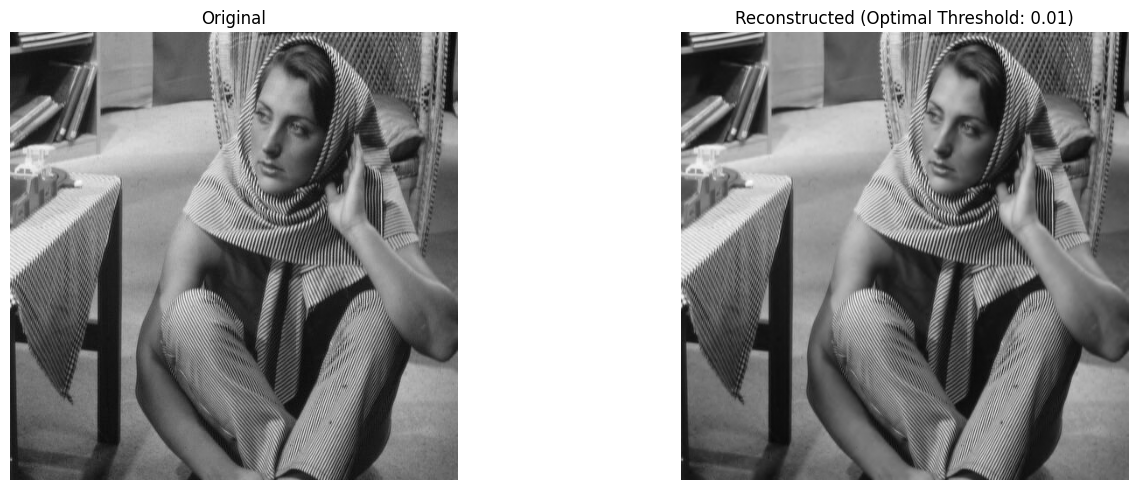

In [55]:
# Plot original and reconstructed images with optimal threshold
reconstructed_optimal = reconstruct_from_measurements(x, A, y, wavelet='sym4', threshold=best_threshold, thresh_mode='garrote')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(x, cmap='gray'); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(reconstructed_optimal, cmap='gray'); axs[1].set_title(f'Reconstructed (Optimal Threshold: {best_threshold})'); axs[1].axis('off')
plt.tight_layout()
plt.show()

The result seem extremely good but the reconstructed image is good.

Let's test other parameter for A and sigma:

In [ ]:
def test_parameters(M, x, mean_A=0.0, std_A=1.0, sigma=0.05, wavelet='sym4', threshold=0.01, thresh_mode='garrote'):
    """
    Test different parameters for A and sigma.
    
    Parameters:
    - M: Number of observations (rows)
    - x: Original signal (image)
    - mean_A: Mean of the normal distribution for matrix A
    - std_A: Standard deviation of the normal distribution for matrix A
    - sigma: Standard deviation of the noise
    - wavelet: Type of wavelet to use for decomposition
    - threshold: Threshold parameter for reconstruction
    - thresh_mode: Thresholding rule ('soft', 'hard', 'garrote')
    
    Returns:
    - None
    """
    # Generate random normal matrix A (standard normal, can generalize to any covariance)
    
    return y

In [ ]:
# Parameters for the random normal matrix A
M = 100  # Number of observations (rows)
N = x_vector.size  # Number of variables (columns) - M < N for underdetermined system
mean_A = 0.0  # Mean of the normal distribution
std_A = 1.0   # Standard deviation
sigma = 0.05

# Generate random normal matrix A (standard normal, can generalize to any covariance)
A = np.random.normal(mean_A, std_A, (M, N))

# Add white Gaussian noise
n = np.random.normal(0, sigma, M)
# Generate the direct problem y = Ax + b (where x is the original signal)
y = A @ x_vector + n